# Bike Sharing Demand

## Forecast use of a city bikeshare system

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/3948/media/bikes.png)

## The Data

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

* **datetime** - hourly date + timestamp  
* **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* **holiday** - whether the day is considered a holiday
* **workingday** - whether the day is neither a weekend nor holiday
* **weather** - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered * **clouds**
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* **temp** - temperature in Celsius
* **atemp** - "feels like" temperature in Celsius
* **humidity** - relative humidity
* **windspeed** - wind speed
* **casual** - number of non-registered user rentals initiated
* **registered** - number of registered user rentals initiated
* **count** - number of total rentals

## Evaluation

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

Where:

* $n$ is the number of hours in the test set
* $p_i$ is your predicted count
* $a_i$ is the actual count
* $log(x)$ is the natural logarithm

### [Kaggle Reference](https://www.kaggle.com/c/bike-sharing-demand)

## Planning

1. Exploration
    1. Load the Data
    1. Inspect the Data Manually
    1. Understand the Data Definition
    1. From Messy to Techically Correct Data
    1. EDA
    1. From Techically Correct to Useful Data
1. Analysis
    1. Hypothesis
    1. Decide on a Model
    1. Run the Model
    1. Evaluate the Model
    1. Hypothesis Testing
    1. Feature Engineering
1. Submission
    1. Submit to Kaggle

## Exploration

### Preliminaries

In [1]:
%matplotlib inline

In [5]:
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *

from IPython.display import HTML
from IPython.display import display as prnt

# Notebook Options
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})

#### Utility Functions

In [17]:
def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

### Load the Data

In [6]:
DATA_DIR = '../data/bikeshare/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'

In [7]:
df = pd.read_csv(TRAIN_FILE)

### Inspect the Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


#### Fix the Datatypes

In [14]:
df.datetime = pd.to_datetime(df.datetime)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1.1 MB


#### Head

In [18]:
table(df.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [22]:
df.holiday.value_counts() / 24

0    440.625000
1     12.958333
dtype: float64

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
262,2011-01-12 09:00:00,1,0,1,1,6.56,6.820,59,22.0028,3,78,81
10164,2012-11-08 22:00:00,4,0,1,1,13.94,15.150,42,19.9995,14,147,161
1877,2011-05-05 03:00:00,2,0,1,1,13.94,15.910,66,16.9979,0,4,4
6518,2012-03-08 20:00:00,1,0,1,2,24.60,31.060,43,26.0027,20,282,302
2489,2011-06-11 15:00:00,2,0,0,1,33.62,38.635,49,7.0015,142,232,374
5291,2011-12-14 13:00:00,4,0,1,2,14.76,18.180,57,7.0015,14,119,133
1851,2011-05-04 01:00:00,2,0,1,3,20.50,24.240,82,19.0012,1,6,7
6729,2012-03-17 16:00:00,1,0,0,1,26.24,31.060,50,0.0000,367,318,685
5052,2011-12-04 14:00:00,4,0,0,1,17.22,21.210,62,8.9981,77,246,323
9706,2012-10-08 19:00:00,4,1,0,2,16.40,20.455,71,16.9979,38,333,371


#### Random sample of rows

In [25]:
from random import sample

df.ix[sample(df.index,10)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
7618,2012-05-16 19:00:00,2,0,1,1,28.70,32.575,54,19.0012,91,499,590
4356,2011-10-13 13:00:00,4,0,1,2,26.24,28.790,83,11.0014,20,142,162
5630,2012-01-09 17:00:00,1,0,1,3,9.02,13.635,87,0.0000,5,147,152
4386,2011-10-14 19:00:00,4,0,1,1,22.14,25.760,39,22.0028,27,221,248
3047,2011-07-15 21:00:00,3,0,1,1,27.06,31.060,54,7.0015,75,186,261
4213,2011-10-07 14:00:00,4,0,1,1,25.42,31.060,50,0.0000,77,179,256
4973,2011-12-01 07:00:00,4,0,1,1,9.84,10.605,65,23.9994,11,265,276
6406,2012-03-04 04:00:00,1,0,0,2,13.94,16.665,46,12.9980,3,11,14
4053,2011-09-19 22:00:00,3,0,1,2,22.96,26.515,68,11.0014,25,104,129
3104,2011-07-18 06:00:00,3,0,1,1,26.24,28.790,83,7.0015,10,95,105


#### Tail

In [27]:
table(df.tail())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


### Univariate

In [29]:
table(df.describe())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [37]:
df.weather.value_counts()

1    7192
2    2834
3     859
4       1
dtype: int64

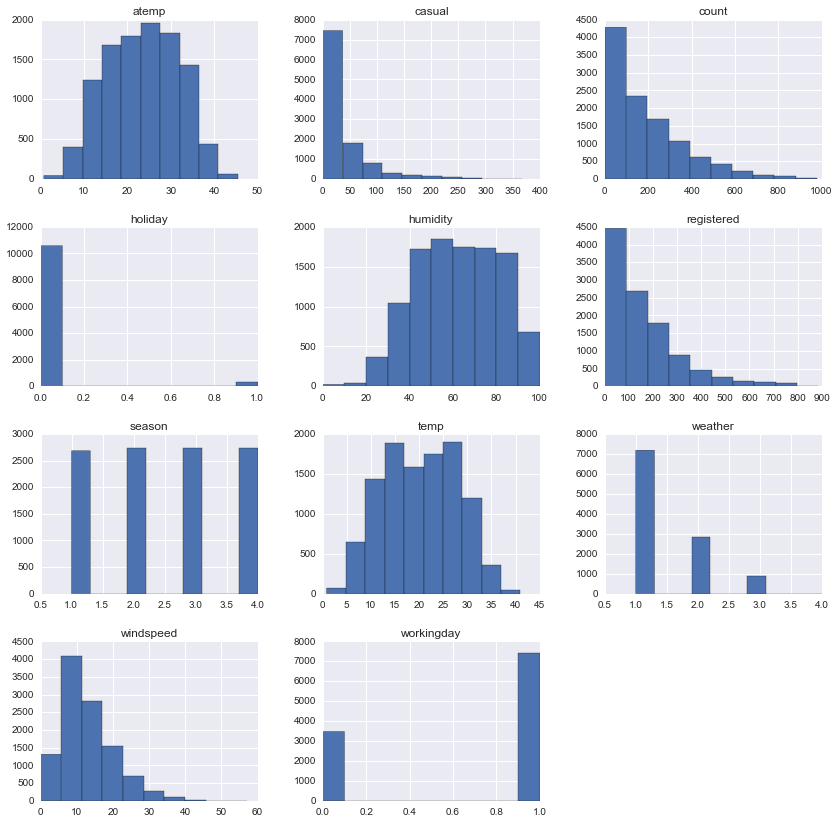

In [36]:
df.hist(figsize=(14,14));

#### Checking for normality

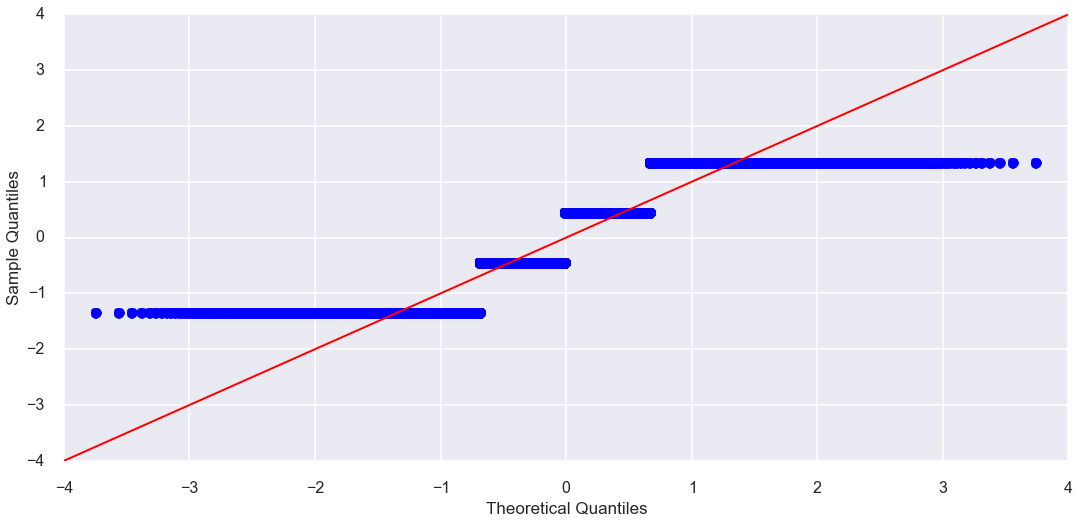

In [46]:
from statsmodels.graphics.gofplots import qqplot

with sns.plotting_context("paper", font_scale=1, rc=c):
    qqplot(df['season'], line='45', fit=True);

### Bivariate

In [ ]:
# Colour Theme
b, g, r, p = sns.color_palette("muted", 4)

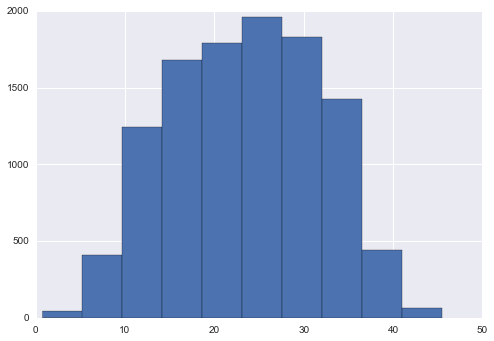

In [51]:
df.atemp.hist(bins=10)

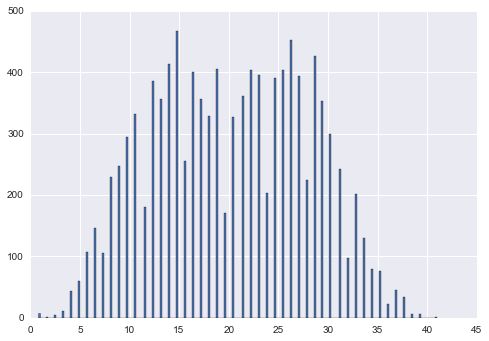

In [54]:
df.temp.hist(bins=200)

In [56]:
df.atemp * (9/5) + 32

0        57.911
1        56.543
2        56.543
3        57.911
4        57.911
5        55.184
6        56.543
7        55.184
8        57.911
9        63.365
10       67.451
11       61.997
12       70.178
13       72.905
14       72.905
15       71.546
16       70.178
17       71.546
18       70.178
19       70.178
20       68.819
21       68.819
22       68.819
23       72.905
24       72.905
25       71.546
26       70.178
27       72.905
28       72.905
29       70.178
          ...  
10856    67.451
10857    67.451
10858    61.997
10859    63.365
10860    61.997
10861    63.365
10862    60.638
10863    60.638
10864    59.270
10865    56.543
10866    53.816
10867    57.911
10868    55.184
10869    56.543
10870    55.184
10871    57.911
10872    61.997
10873    68.819
10874    68.819
10875    70.178
10876    70.178
10877    70.178
10878    70.178
10879    68.819
10880    67.451
10881    67.451
10882    63.365
10883    60.638
10884    63.365
10885    61.997
Name: atemp, dtype: floa

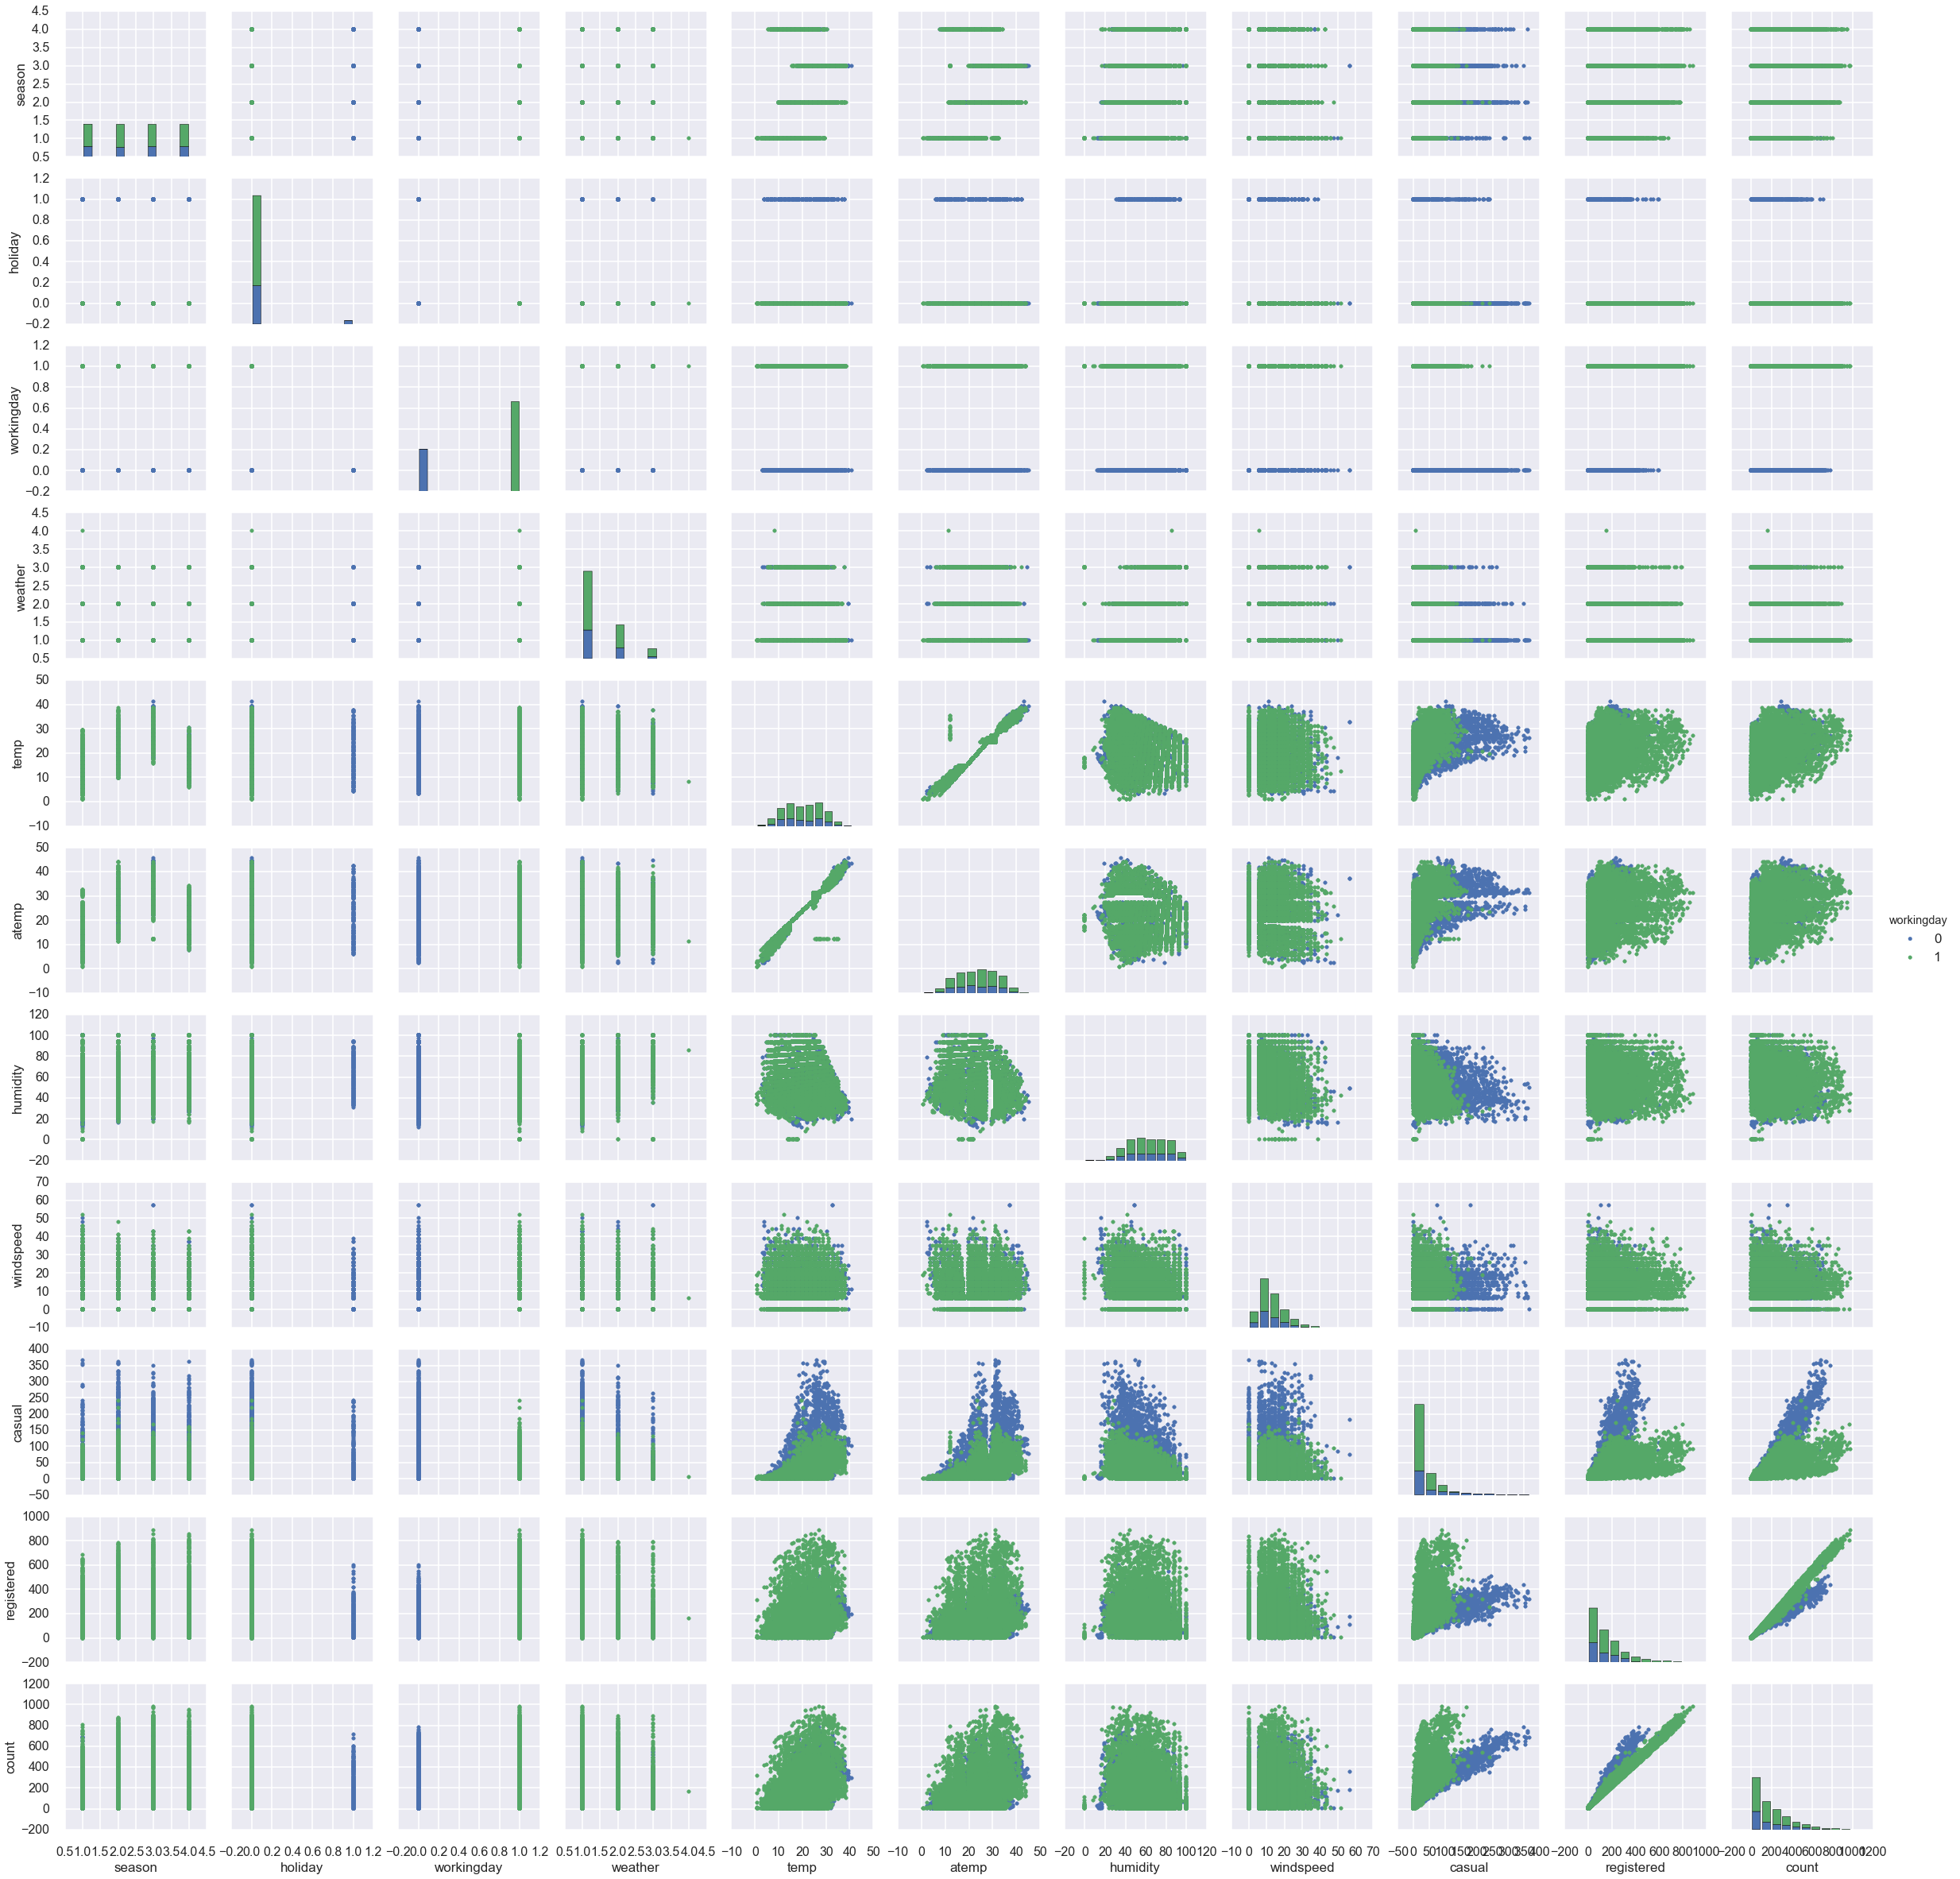

In [58]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.PairGrid(df, hue="workingday")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()

#### Working Day vs. Count

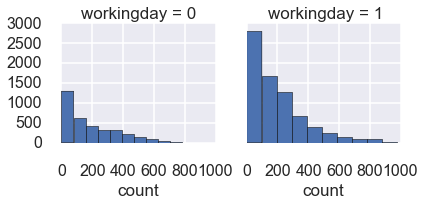

In [57]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.FacetGrid(df, col="workingday")
    g.map(plt.hist, "count");

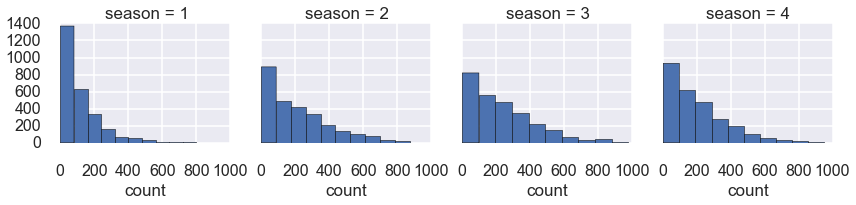

In [59]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.FacetGrid(df, col="season")
    g.map(plt.hist, "count");

### Multivariate

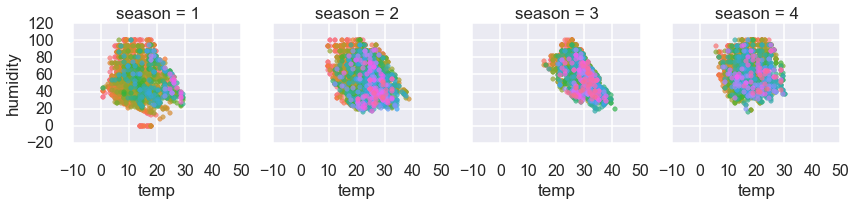

In [69]:
with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.FacetGrid(df, col="season", hue="count")
    g.map(plt.scatter, "temp", "humidity", alpha=.7, cmap='Blues')

## Analysis

In [70]:
df.columns

Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp',
       u'atemp', u'humidity', u'windspeed', u'casual', u'registered',
       u'count'],
      dtype='object')

### Training / Test Split

In [71]:
def get_train_data():
    # Loads the training data, but splits the y from the X
    df = pd.read_csv(TRAIN_FILE)
    return df.iloc[:, 0:9], df.iloc[:,-1]

### Scoring Method

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [142]:
np.log(-1)

nan

In [86]:
from sklearn.metrics import make_scorer

def rmsele(actual,pred):
    """Given a column of predictions and a column of actuals, calculate the RMSELE
    """
    squared_errors = (np.log(pred + 1) - np.log(actual + 1)) ** 2
    mean_squared = np.sum(squared_errors) / len(squared_errors)
    return np.sqrt(mean_squared)

# This helper function will make a callable that we can use in cross_val_score
rmsele_scorer = make_scorer(rmsele, greater_is_better=False)

### Baseline Model

In [96]:
yhat = np.array([df['count'].mean()] * df['count'].count())
y    = df['count']

rmsele(y,yhat)

1.5691983019475926

In [141]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold, cross_val_score


X, y = get_train_data()

feat = ['temp','humidity','season','atemp','workingday']

Xhat = X[feat]

ridge_estimator = Ridge(normalize=True)

scores = cross_val_score(ridge_estimator, Xhat, y, scoring=rmsele_scorer, cv=10, verbose=2)
scores

[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] n

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished



[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -   0.0s


array([-1.79364893, -1.52967862, -1.43767518, -1.46484218, -1.4646107 ,
       -1.45693044, -1.39132307, -1.31475065, -1.30446582, -1.28286064])

### Simple Model

In [120]:
# Fill in some of the parameters on cross_val_score
def perform_cv(estimator, X, y):
    return cross_val_score(estimator, X, y, scoring=rmsele_scorer, cv=5, verbose=1)

In [123]:
parameters = {'alpha': np.logspace(0, 3, 10)}
parameters

{u'alpha': array([    1.        ,     2.15443469,     4.64158883,    10.        ,
           21.5443469 ,    46.41588834,   100.        ,   215.443469  ,
          464.15888336,  1000.        ])}

In [125]:
from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(ridge_estimator, parameters, scoring=rmsele_scorer, cv=5)
grid

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, solver='auto', tol=0.001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={u'alpha': array([    1.     ,     2.15443,     4.64159,    10.     ,    21.54435,
          46.41589,   100.     ,   215.44347,   464.15888,  1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(rmsele, greater_is_better=False), verbose=0)

In [135]:
from sklearn.grid_search import GridSearchCV

# Try a simple grid search with the estimator
parameters = {'alpha': np.logspace(0, 2, 10)}
grid = GridSearchCV(ridge_estimator, parameters, scoring=rmsele_scorer, cv=5)
grid.fit(Xhat, y)
grid.best_estimator_

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, solver='auto', tol=0.001)

In [134]:
# And for grid_search
def perform_grid_search(estimator, parameters, X, y):
    grid_search = GridSearchCV(estimator, parameters, scoring=rmsele_scorer, cv=5)
    grid_search.fit(X, y)
    return grid_search

### Floored

In [132]:
from sklearn.linear_model import Ridge

# Custom Ridge to floor predictions at 0
class FlooredRidge(Ridge):
    def predict(self, X, *args, **kwargs):
        pred = super(FlooredRidge, self).predict(X, *args, **kwargs)
        pred[pred < 0] = 0
        return pred

## Submisison

In [2]:
from IPython.display import HTML

HTML('''<script>

code_show=true;

function code_toggle() {
    if (code_show){ 
        $('div.input').hide();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').hide();
    } else {
        $('div.input').show();
        $('.output_scroll').removeClass('output_scroll');
        $('.prompt').show();
    }
    code_show = !code_show
}
</script>
 
<a class='btn btn-warning btn-lg' style="margin:0 auto; display:block; max-width:320px" href="javascript:code_toggle()">TOGGLE CODE</a>''')

In [3]:
HTML('''<link href='http://fonts.googleapis.com/css?family=Roboto|Open+Sans' rel='stylesheet' type='text/css'>
<style>
body #notebook {
    font-family : 'Open Sans','Source Sans Pro','Proxima Nova', sans-serif;
    font-size : 1.3em;
    line-height : 1.5em;
}

h1,h2,h3,h4,h5 {
    font-family : 'Roboto','Source Sans Pro','Proxima Nova', sans-serif;
}


#notebook .panel-body {
  font-size: 1.1em;
  line-height: 1.6em;
}

#notebook .table,
#notebook .table th,
#notebook .table td,
#notebook .table tr {
    text-align : center;
    border: 0;
}
</style>

<script>
$(function(){
    code_toggle()
})
</script>

''')